In [2]:
# Load needed Python modules
import numpy as np
import matplotlib.pyplot as plt
import os
import netCDF4
import astropy
import scipy
import calendar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.convolution import convolve as ap_convolve
from astropy.convolution import Box2DKernel
from matplotlib.axes import Axes
from netCDF4 import num2date
from scipy import stats

In [23]:
# plot function
def make_plot(data, num, cc, plttitle, vmin_val, vmax_val):
    if num == None:
        fig=plt.imshow(sstReg, origin='lower', cmap='prism')
        plt.xticks([0, xhi-xlo], [lonmin, lonmax])
        plt.yticks([0, (yhi-ylo)/2, yhi-ylo], [latmin, ((latmax-latmin)/2)+latmin, latmax])
        plt.tick_params(axis='both', labelsize=7)
        plt.title('SST', size=14)
        plt.colorbar(fig)
    else:
        ax=plt.subplot(num)
        fig=plt.imshow(data, origin='lower', cmap=cc, vmin=vmin_val, vmax=vmax_val)
        plt.xticks([0, xhi-xlo], [lonmin, lonmax])
        plt.yticks([0, (yhi-ylo)/2, yhi-ylo], [latmin, ((latmax-latmin)/2)+latmin, latmax])
        ax.tick_params(axis='both', labelsize=7)
        plt.title(plttitle, size=10)

        # Make colorbar lined up with figure and resize label
        divider=make_axes_locatable(ax)
        cax=divider.append_axes("right", size="5%", pad=0.05)
        cbar=plt.colorbar(fig, cax=cax)
        ticklabs=cbar.ax.get_yticklabels()
        cbar.ax.set_yticklabels(ticklabs, fontsize=7)

In [4]:
# Histogram function
def make_hist(data, num):
    ax = plt.subplot(num)
    ax.tick_params(axis='both', labelsize=7)
    phi = data.flatten()
    hist = plt.hist(phi, bins=50)
        
    # sst labels change to phi see if no str works, look at format statments
    dmax = np.nanmax(phi)
    dmin = np.nanmin(phi)
    dmean = np.nanmean(phi)    
    dstd = np.nanstd(phi)
    dskew = stats.mstats.skew(phi, axis=None)
    dkurt = stats.mstats.kurtosis(phi, axis=None)
    plt.xlabel(f'max: {dmax:.3f}\n min: {dmin:.3f}\n mean: {dmean:.3f}\n std: {dstd:.3f}\n skew: {dskew:.3f}\n kurtosis: {dkurt:.3f}', size=7)

In [5]:
# Convolve data
def conv_for_vis(data, size):
    box_2D_kernel = Box2DKernel(size)
    nan=float('nan')
    data=np.ma.filled(data,nan)
    data[ :, 0]=nan
    data[ 0, :]=nan
    data[ :,-1]=nan
    data[-1, :]=nan
    data2=ap_convolve(data, box_2D_kernel)
    conv=data2
    conv=conv[size:-size, size:-size]
    conv=np.ma.masked_invalid(conv)
    return conv

In [25]:
def extract_data(file):
    # Extract data from file
    sst=file['analysed_sst']
    date_num = file['time'][:]
    units = file.variables['time'].units
    date = num2date(date_num, units)[0]
    date = str(date)
    date = date[:10]

    # Extract a subregion
    sstReg=sst[0, ylo:yhi, xlo:xhi]-273.

    # Extract coordinate data
    lat = file.variables['lat']
    lon = file.variables['lon']
    latmin = (ylo/100) + lat.valid_min
    lonmin = (xlo/100) + lon.valid_min
    latmax = (yhi/100) + lat.valid_min
    lonmax = (xhi/100) + lon.valid_min
    file_info = (sstReg, date, latmin, lonmin, latmax, lonmax)
    return file_info

/home/culberta/hill-2018/miniconda3/envs/pangeo/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/culberta/hill-2018/miniconda3/envs/pangeo/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


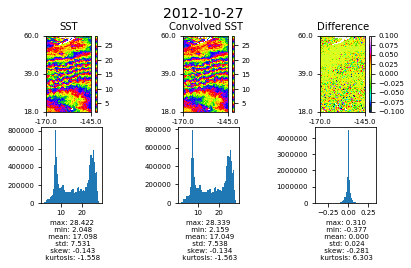

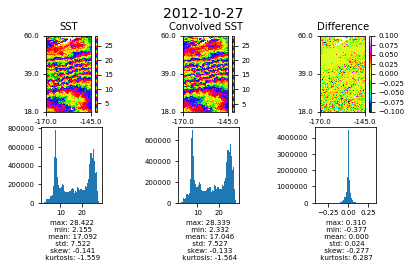

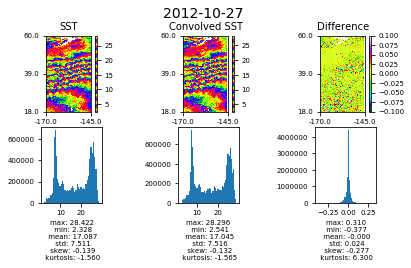

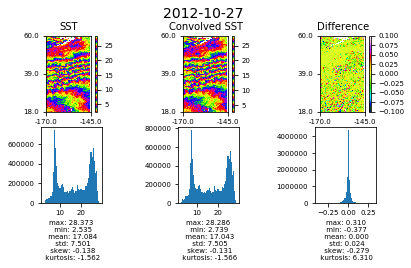

In [ ]:
# Change to SSD with files
os.chdir('/nfs/cnhlab003/cnh')

# Choose x and y range
yhi = 15000
ylo = 10800
xhi = 3500
xlo = 1000

tFile_info=extract_data(tFile)
sstReg, date=tFile_info[0], tFile_info[1]
latmin, lonmin=tFile_info[2], tFile_info[3]
latmax, lonmax=tFile_info[4], tFile_info[5]

# Determine size of boxes data will be convolved over
#def main_func(boxsize):
for filename in os.listdir('mur-sst'):
        if filename[:4] == '2012':   
            boxsize=9
            
            # Create "handle" to access netCDF file
            tFile = netCDF4.Dataset('mur-sst/'+filename)
            extract_data(tFile)

            # Make sst data plots
            make_plot(sstReg, 231, 'prism', 'SST', None, None)
            make_hist(sstReg, 234)

            # Convolve sst data
            conv = conv_for_vis(sstReg, boxsize)

            # Make convolved data plots
            make_plot(conv, 232, 'prism', 'Convolved SST', None, None)
            make_hist(conv, 235)

            # Find difference between original and convolved data
            sstReg=sstReg[boxsize:-boxsize, boxsize:-boxsize]
            dif = sstReg - conv

            # Difference data plots
            make_plot(dif, 233, 'gist_ncar',  'Difference', -0.1, 0.1)
            dif = dif[np.logical_not(np.isnan(dif))] # Removes nan values from histogram
            make_hist(dif, 236)

            # Format plots
            plt.suptitle(date, fontsize=14)
            plt.subplots_adjust(wspace = 1.25, bottom = 0.3)

            # Save and show fig
            month = calendar.month_name[int(filename[4:6])]
            os.chdir('/home/culberta/public_html/sstconvdif-imgs-2012/'+month)
            plt.savefig(str(date) + '.png', dpi = 200)
            plt.show()
            plt.clf()
            os.chdir('/nfs/cnhlab003/cnh')

#for filename in os.listdir('mur-sst'):
#        if filename[:4] == '2012':
#           main_func(9)

In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_widgets
from IPython.display import display
y = interactive(main_func, boxsize=9)
display(y)

ModuleNotFoundError: No module named 'ipywidgets'